# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>


In this notebook I performed Molecular Dynamics (MD) and Monte Carlo (MC) simulations of a Lennard–Jones fluid in the liquid phase. The study focused on the implementation of tail corrections, the equilibration of both MD and MC runs, and the estimation of statistical uncertainties using autocorrelation analysis and the data blocking method. I implemented the radial distribution function $g(r)$ through a histogram approach and compared results obtained from MD (microcanonical ensemble) and MC (canonical ensemble) simulations. 

This notebook is organized into four main section:

1. [Tail Corrections](#tail-corrections)
2. [Simulations Setup](#simulations-Setup):
        Equilibration, autocorrelation, datablocking
3. [Radial Distribution Function $g(r)$](#radial-distribution-function-$g(r)$)
4. [Results of the Simulations](#results-of-the-simulations)

# Tail Corrections

In molecular simulations with periodic boundary conditions, it is not possible to include all pair interactions due to the infinite number of periodic images. To handle this, one adopts the minimum image convention, which in turn implies the introduction of a cutoff radius $r_c$.

By construction, the pair potential is then set to zero for $r > r_c$. However, this truncation introduces a systematic error because the true potential is not zero beyond the cutoff. To compensate for the missing long-range contributions, one introduces **tail corrections**. 

I explicitly modified the `NSL_Simulator` code to include these **tail corrections** for both the potential energy and the pressure.
Assuming that for $ r>r_c $ the $ g(r) $ is approximately 1 we obtain the formulas:
$$
\frac{V_{\mathrm{LJ}}^{\mathrm{tail}}}{N}
=
8 \,\pi\,\rho\,\varepsilon
\Biggl(
\frac{\sigma^{12}}{9\,r_c^{9}}
-
\frac{\sigma^{6}}{3\,r_c^{3}}
\Biggr) ,
$$ 

$$
\frac{w_{\mathrm{LJ}}^{\mathrm{tail}}}{3\,N\,\varepsilon}
=
32 \,\pi\,\rho
\Biggl(
\frac{\sigma^{12}}{9\,r_c^{9}}
-
\frac{\sigma^{6}}{6\,r_c^{3}}
\Biggr) .
$$



These tail corrections provide only a small contribution, since in the region $r > r_c$ the particles are essentially uncorrelated and the resulting contribution to the sum of interactions is weak.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_equilibration(md_temp_file, mc_accept_file, mc_pot_file, nsteps=5000, T_target=1.1):
    """
    Plots equilibration transients:
    - MD instantaneous temperature
    - MC acceptance ratio
    - MC instantaneous temperature

    Parameters
    ----------
    md_temp_file : str
        Path to MD instantaneous temperature file (e.g. "settings/moleculardynamics/OUTPUT/istant_temperature.dat")
    mc_accept_file : str
        Path to MC acceptance file (e.g. "settings/montecarlo/OUTPUT/acceptance.dat")
    mc_temp_file : str
        Path to MC instantaneous potential file (e.g. "settings/montecarlo/OUTPUT/istant_potential.dat")
    nsteps : int, optional
        Number of steps to plot (default=5000)
    T_target : float, optional
        Target reduced temperature (default=1.1)
    """
    # Load data
    istant_temp_md = np.loadtxt(md_temp_file)
    accettanza = np.loadtxt(mc_accept_file, usecols=1)
    istant_pot_mc = np.loadtxt(mc_pot_file)

    # x-axis
    x = np.arange(min(nsteps, len(istant_temp_md), len(accettanza), len(istant_pot_mc)))

    # Create figure with 3 subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    # --- MD Temperature ---
    axs[0].plot(x, istant_temp_md[:len(x)], label="MD Instant Temperature")
    axs[0].axhline(y=T_target, color="red", linestyle="--", linewidth=1, label=fr"$T^*={T_target}$")
    axs[0].set_ylabel(r"$T^*$", fontsize=14)
    axs[0].set_title("MD Equilibration", fontsize=16)
    axs[0].grid(True)
    axs[0].legend()

    # --- MC Acceptance ---
    axs[1].plot(x, accettanza[:len(x)],color='orange', label="MC Acceptance")
    axs[1].axhline(y=accettanza[-1], color="red", linestyle="--", linewidth=1, label="Target acceptance")
    axs[1].set_ylabel("Acceptance", fontsize=14)
    axs[1].set_ylim([0.45, 0.75])
    axs[1].set_title("MC Acceptance Equilibration", fontsize=16)
    axs[1].grid(True)
    axs[1].legend()

    # --- MC Istant U ---
    axs[2].plot(x, istant_pot_mc[:len(x)],color='orange', label="MC Instant Potential Energy")
    axs[2].set_xlabel("# steps", fontsize=14)
    axs[2].set_ylabel(r"$U/N$", fontsize=14)
    axs[2].set_title("MC Potential Energy Equilibration", fontsize=16)
    axs[2].grid(True)
    axs[2].legend()

    plt.tight_layout()
    plt.show()


# Simulations setup



I performed simulations of $N = 108$ particles in the **liquid phase**, at reduced density and temperature  

$$
\rho^\star = 0.8, \quad T^\star = 1.1 ,
$$  

using a cutoff radius of $r_c^\star = 2.5$. For the Molecular Dynamics simulations I adopted a reduced time step $dt^\star = 0.001$.  

The **initial positions** of the particles were set according to a face-centered cubic (fcc) lattice, corresponding to a configuration close to the minimum of the Lennard–Jones potential. 


## Equilibration

As a first step, I studied the **equilibration** of both Monte Carlo (MC) and Molecular Dynamics (MD) simulations in order to ensure that the systems had reached a stationary regime before collecting data.  

**Molecular Dynamics (MD):**  
At the beginning of the MD simulation, the instantaneous temperature was found to start from a higher value, around $T^\star \approx 2$, and to decrease towards the desired target $T^\star = 1.1$. I simulated the system for 5000 steps and plotted the instantaneous temperature as a function of the MD steps.  

The plot shows a **sharp decrease** of the temperature during the first $\sim 100$ steps, followed by an **oscillatory regime** around the desired value $T^\star = 1.1$.   

Based on these observations, I decided to **discard the first $10^3$ steps** of the MD simulation when computing average values.  

**Monte Carlo (MC):**  
For the Monte Carlo simulation, I tested different values of the montecarlo step and found that $dt = 0.101$ yields an **acceptance ratio close to 50%**, which is the optimal range for an efficient simulation. I simulated the system for 5000 MC steps and plotted both the instantaneous acceptance and the potential energy per particle.  

The acceptance starts around **67%** and quickly decreases, stabilizing at about **51–52%**, which confirms that the choice of the step size is appropriate. By comparing the instantaneous acceptance with its final value, it is evident that after roughly 2000 steps the curve and the horizontal reference line are practically indistinguishable.  

The instantaneous potential energy per particle, $U/N$, also stabilizes after about **500–1000 steps**, reaching a plateau around **$-5.5$** with small oscillations. This indicates that the system rapidly reaches equilibrium conditions.  

Therefore, for the MC simulations I decided to **discard the first 2000 steps** before computing equilibrium averages.  

 




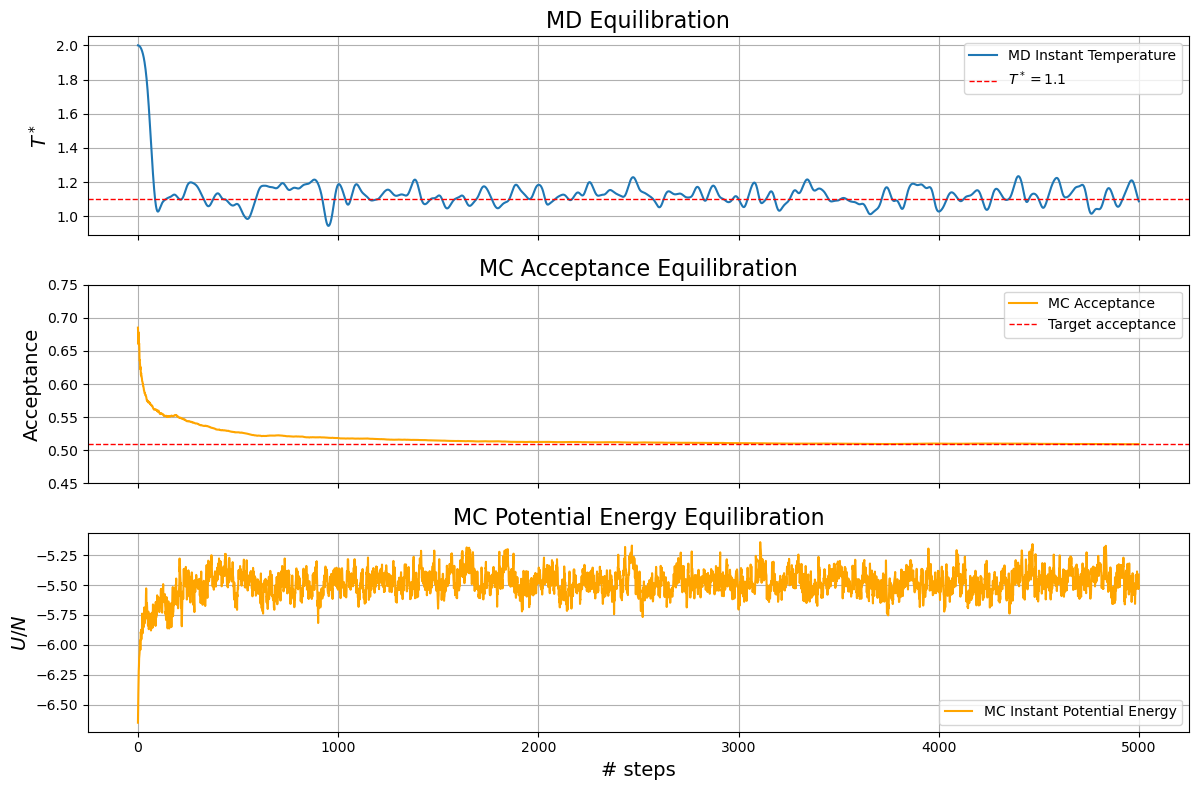

In [6]:
temp_md='settings/moleculardynamics/OUTPUT/istant_temperature.dat'
acc_mc='settings/montecarlo/OUTPUT/acceptance.dat'
pot_mc='settings/montecarlo/OUTPUT/istant_potential.dat'
plot_equilibration(temp_md,acc_mc,pot_mc)

**Figure 1:** *Equilibration of the system in the liquid phase ($\rho^\star = 0.8$, $T^\star = 1.1$). MD temperature (top) rapidly relaxes to the target value. MC acceptance (middle) stabilizes around 51–52%. MC potential energy per particle (bottom) reaches a plateau near $-5.5$. Initial transients are discarded (1000 steps for MD, 2000 steps for MC).*  


After the equilibration phase, the simulations were **restarted**:  
- the **final configuration** of the equilibration run was used as the **initial configuration** for the production (equilibrium) simulation,  
- the random seed saved in the file `seed.out` at the end of the equilibration run was used as the new input seed (`seed.in`) for the restarted simulation.  

I then used the **NSL_Simulator** code to print out the **instantaneous values** of the potential energy per particle, $U/N$, during **equilibrated** Monte Carlo $(N,V,T)$ and Molecular Dynamics $(N,V,E)$ simulations. Each run consisted of $M = 5 \times 10^5$ Monte Carlo steps or Molecular Dynamics time steps.  


## Autocorrelation

To properly estimate statistical uncertainties from simulation data, it is important to account for the fact that consecutive measurements are not fully independent but correlated in time. This correlation can be quantified by the **autocorrelation function**.  

For an observable $A$, computed over $N_{\rm tot}$ data points, the normalized autocorrelation at lag $N$ is defined as  

$$
\chi(N) 
=
\frac{
  \displaystyle
    \frac{1}{N_{\rm tot}-N}
    \sum_{k=0}^{\,N_{\rm tot}-N}
      A_{k}\,A_{k+N}
  \;-\;
  \Bigl(\frac{1}{N_{\rm tot}-N}\sum_{k=0}^{\,N_{\rm tot}-N}A_{k}\Bigr)
  \Bigl(\frac{1}{N_{\rm tot}-N}\sum_{k=0}^{\,N_{\rm tot}-N}A_{k+N}\Bigr)
}{
  \displaystyle
    \frac{1}{N_{\rm tot}}
    \sum_{k=0}^{\,N_{\rm tot}}A_{k}^{2}
  \;-\;
  \Bigl(\frac{1}{N_{\rm tot}}\sum_{k=0}^{\,N_{\rm tot}}A_{k}\Bigr)^{2}
}
$$

with $\chi(0)=1$ by construction and $\chi(N)\to 0$ as $N$ increases.  

In the context of Monte Carlo and Molecular Dynamics simulations, studying the autocorrelation of the potential energy per particle $U/N$ is crucial to determine the **correlation time** of the data. This, in turn, guides the choice of the **block length** in block averaging methods: the block size must be much larger than the correlation time to ensure that block averages are effectively uncorrelated.  

In my analysis, I computed $\chi(N)$ for $U/N_{part}$ using the first $10^4$ data points from both MC and MD simulations, through a dedicated Python function. This analysis allowed me to set an appropriate block length for reliable error estimation.


In [25]:
def autocorrelation(x):
    """
    Compute the normalized autocorrelation of x for all lags N = 0 .. len(x)-1
    """
    n = len(x)                 # length of the time series
    var = np.var(x)            # variance of x (denominator of the formula)
    acorr = np.zeros(n)        # output array

    # loop over all possible lags
    for lag in range(n):
        N_lag = n - lag        # number of terms available for this lag
        sum1 = 0.0             # accumulator for Σ x[k]*x[k+lag]
        sum2 = 0.0             # accumulator for Σ x[k]
        sum3 = 0.0             # accumulator for Σ x[k+lag]

        # accumulate sums over valid indices
        for k in range(N_lag):
            sum1 += x[k] * x[k + lag]
            sum2 += x[k]
            sum3 += x[k + lag]

        frac = 1.0 / N_lag     # normalization factor
        numerator = frac * sum1 - (frac * sum2) * (frac * sum3)  # numerator χ(N)
        acorr[lag] = numerator / var  # normalize with variance

    return acorr               # return the autocorrelation array


    

def plot_autocorrelation(md_file, mc_file, npoints=10000):
    """
    Plot autocorrelation of the instantaneous potential energy
    for MD and MC simulations.

    Parameters
    ----------
    md_file : str
        Path to the MD instantaneous potential file.
    mc_file : str
        Path to the MC instantaneous potential file.
    npoints : int, optional
        Number of data points to use for autocorrelation (default=10000).
    """
    # Load data
    istant_pot_md = np.loadtxt(md_file)[:npoints]
    istant_pot_mc = np.loadtxt(mc_file)[:npoints]

    # Compute autocorrelations
    autocorr_md = autocorrelation(istant_pot_md)
    autocorr_mc = autocorrelation(istant_pot_mc)

    # X-axis
    nsteps = len(autocorr_mc)
    x = np.arange(nsteps)

    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    # MD
    axs[0].plot(x, autocorr_md, label="MD")
    axs[0].set_xlabel("# steps", fontsize=16)
    axs[0].set_ylabel(r"$\chi(N)$", fontsize=16)
    axs[0].set_title("Autocorrelation of instantaneous potential (MD)", fontsize=16)
    axs[0].grid(True)
    axs[0].legend()

    # MC
    axs[1].plot(x, autocorr_mc, color='orange' ,label="MC")
    axs[1].set_xlabel("# steps", fontsize=16)
    axs[1].set_ylabel(r"$\chi(N)$", fontsize=16)
    axs[1].set_title("Autocorrelation of instantaneous potential (MC)", fontsize=16)
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()



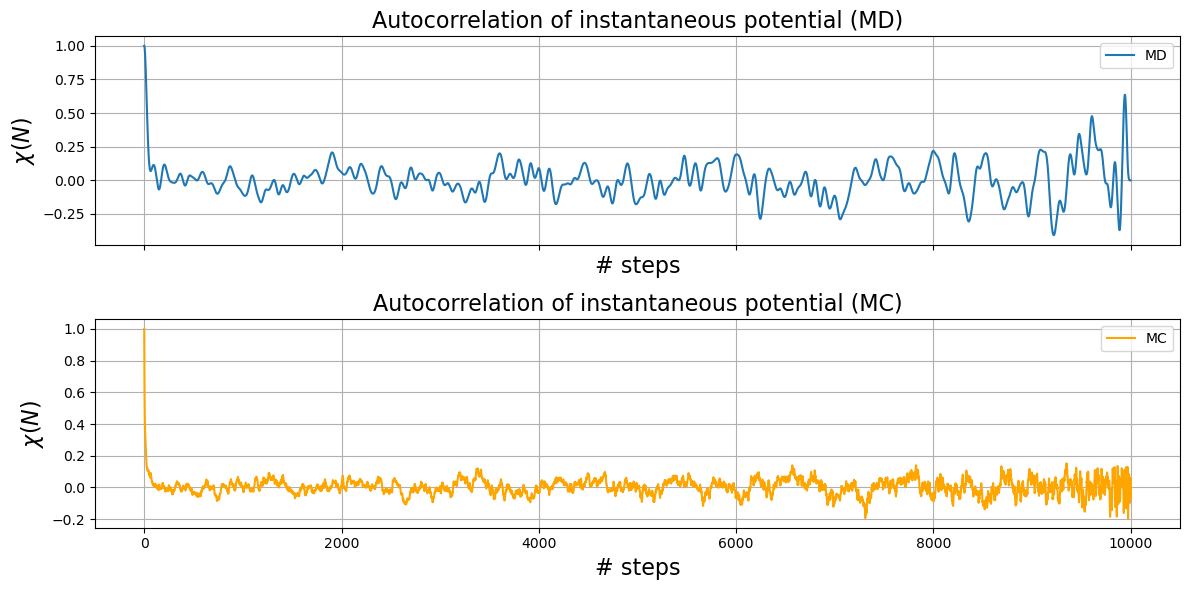

In [26]:
plot_autocorrelation(
    "moleculardynamics/running/OUTPUT/istant_potential.dat",
    "montecarlo/running/OUTPUT/istant_potential.dat",
    npoints=10000
)

**Figure 2:** *Autocorrelation of the instantaneous potential energy per particle, $U/N$, for MD (top) and MC (bottom) simulations, computed over the first $10^4$ data points. In both cases, the autocorrelation function $\chi(N)$ rapidly decays to values close to zero within the first few hundred steps, and then fluctuates around zero with small amplitude. This indicates that the correlation time of the data is relatively short.*  

From these results, I conclude that the block length used in the blocking analysis should be significantly larger than the autocorrelation time. A safe choice is to adopt **blocks of at least 500–1000 data points**, ensuring that block averages can be considered statistically independent.


## Datablocking

To estimate the statistical uncertainties of the expectation value of the potential energy per particle, $U/N$, I applied the **data blocking technique** to both MC and MD simulations.  

I implemented a Python function that performs data blocking by dividing the total dataset ($M = 5 \times 10^5$ measurements) into $N$ blocks of equal length $L = M/N$. 
I then implemented a second function that plots the statistical uncertainty of the last block as a function of the block length $L \in [10,5000]$, keeping $M$ fixed. For each block size, I computed the mean and the standard error of the block averages. Finally, I plotted in a single figure the resulting uncertainties as a function of $L$, directly comparing the outcomes of MC and MD simulations

The results show that when the block size $L$ is **small**, the data inside each block are still strongly correlated. In this regime, the correlations lead to an **underestimation of the statistical error**. As $L$ increases, correlations between blocks are progressively reduced, and beyond a certain threshold (much larger than the autocorrelation time) the estimated uncertainty reaches a **stable plateau**, providing a reliable estimate of the true statistical error.


In [14]:
def datablocking(x: np.ndarray, N: int):
    M = len(x)
    L = M // N  # block length (integer division)

    ave      = np.zeros(N)
    ave_prog = np.zeros(N)
    err      = np.zeros(N)

    sum_ave  = 0.0
    sum_ave2 = 0.0

    for i in range(N):
        block_sum = np.sum(x[i*L : (i+1)*L])
        ave[i]    = block_sum / L

        sum_ave  += ave[i]
        sum_ave2 += ave[i]**2

        ave_prog[i] = sum_ave / (i+1)
        if i == 0:
            err[i] = 0.0
        else:
            mean2 = sum_ave2/(i+1)
            mean  = ave_prog[i]
            err[i]= np.sqrt((mean2 - mean**2) / i)

    return ave_prog, err


def plot_datablocking_errors_2(M=500_000, Lmin=10, Lmax=5000):
    istant_pot_md = np.loadtxt('moleculardynamics/running/OUTPUT/istant_potential.dat')
    istant_pot_mc = np.loadtxt('montecarlo/running/OUTPUT/istant_potential.dat')

    block_lengths = np.arange(Lmin, Lmax+1)
    err_last_md = np.zeros(len(block_lengths))
    err_last_mc = np.zeros(len(block_lengths))

    for idx, b in enumerate(block_lengths):
        N = M // b
        if N < 2:  # serve almeno 2 blocchi per stimare l’errore
            err_last_md[idx] = np.nan
            err_last_mc[idx] = np.nan
            continue
        # tronco i dati al multiplo di b più vicino
        L_eff = N * b
        data_md = istant_pot_md[:L_eff]
        data_mc = istant_pot_mc[:L_eff]

        _, err_md = datablocking(data_md, N)
        _, err_mc = datablocking(data_mc, N)

        err_last_md[idx] = err_md[-1]
        err_last_mc[idx] = err_mc[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(block_lengths, err_last_md, '-', color="blue", label="MD error")
    plt.plot(block_lengths, err_last_mc, '-', color="orange", label="MC error")
    plt.xlabel("Block length L", fontsize=14)
    plt.ylabel("Estimated error", fontsize=14)
    plt.title("Data Blocking: Error vs Block Length", fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


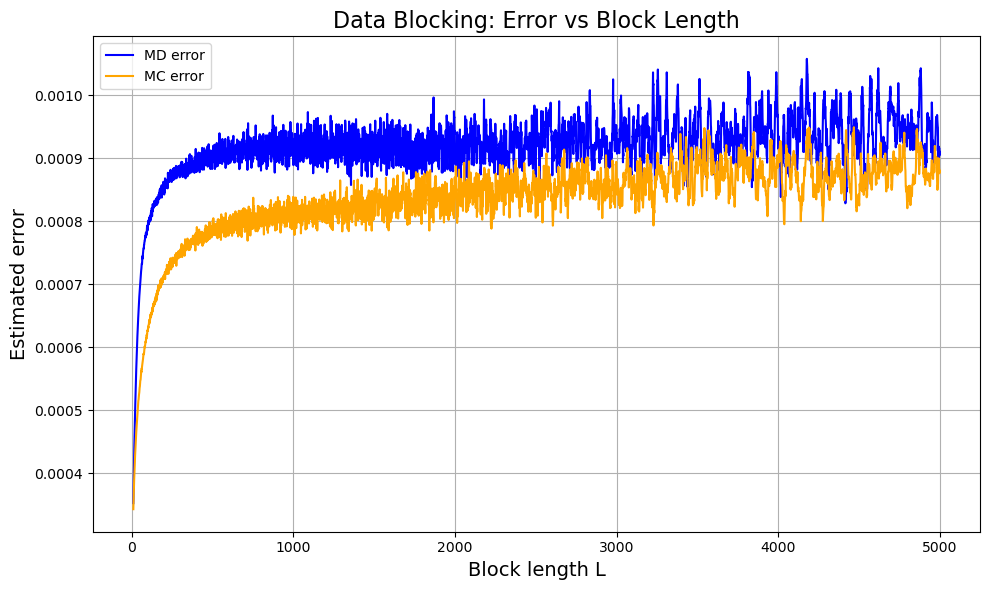

In [15]:
plot_datablocking_errors_2()

**Figure 3**: Estimated statistical uncertainty(last block error) of the potential energy per particle, $U/N$, as a function of the block length $L$, obtained with the data blocking method for MD (blue) and MC (orange) simulations. 

The behavior observed is consistent with the autocorrelation analysis: when $L$ is too small, correlations between data points cause an underestimation of the error. Increasing $L$ reduces correlations, and beyond about $L \gtrsim 1000$ the estimated error reaches a stable plateau. Based on this result, I chose a block length of 2000 steps for both MC and MD simulations, which is safely larger than the correlation time and ensures reliable estimates of statistical uncertainties

# Radial density function $ g(r) $

### Theoretical Background on the Radial Distribution Function

The **radial distribution function** $g(r)$, also called the pair distribution function, is one of the most important structural quantities for characterizing simple fluids. It represents the probability of finding two particles separated by a distance $r$, relative to that expected for an ideal gas at the same density .  

Formally, for a homogeneous and isotropic system, $g(r)$ depends only on the modulus of the distance between two particles and is related to the two-particle density $\rho^{(2)}(\mathbf{r}_1, \mathbf{r}_2)$ through:  

$$
g(r) = \frac{\rho^{(2)}(\mathbf{r}_1,\mathbf{r}_2)}{\rho^2} ,
\qquad r = |\mathbf{r}_1 - \mathbf{r}_2| .
$$  

For an ideal gas, where particles are completely uncorrelated, one has $g(r) = 1$. In a real fluid, however, $g(r)$ exhibits oscillations that reflect short-range order:  
- a strong **correlation hole** at small $r$ due to repulsive interactions,  
- a **first peak** corresponding to the most probable nearest-neighbor distance,  
- damped oscillations at larger distances, converging to $g(r) \to 1$.  

### Implementation of the Radial Distribution Function $g(r)$

I implemented the radial distribution function $g(r)$ using a **histogram method**.  
At each measurement step, I considered all particle pairs $(i,j)$ with $i<j$ and computed their mutual distance $dr$ under periodic boundary conditions.  

1. **Histogram accumulation**:  
   I divided the interval $[0, L/2]$ into $N_{\text{bins}}$ bins of width  
   $$
   \Delta r = \frac{L/2}{N_{\text{bins}}}.
   $$  
   Each pair distance $dr$ was assigned to the corresponding bin, and I incremented the bin count by **2**, since both $i \to j$ and $j \to i$ contribute.  

2. **Normalization**:  
   At the end of each block, I normalized the raw histogram counts by the number density $\rho$, the number of particles $N$, and the volume of the spherical shell associated with the bin,  
   $$
   \Delta V = \frac{4}{3}\pi \big[(r+\Delta r)^3 - r^3\big].
   $$  
   This gives  
   $$
   g(r) = \frac{\langle N_{\text{pairs}}(r) \rangle}{\rho \, N \, \Delta V}.
   $$  

3. **Output**:  
   For each bin, I printed to `gofr.dat` the block average, the progressive average over blocks, and the statistical error obtained through the blocking method.  

With this approach, I obtained a properly normalized histogram representation of $g(r)$, which approaches $1$ at large distances as expected for a homogeneous liquid.


# Results of the Simulations

I performed simulations of Argon, modeled with a Lennard–Jones potential with parameters $\sigma = 0.34 \,\text{nm}$, $\epsilon/k_B = 120 \,\text{K}$, and $m = 39.948 \,\text{amu}$.  

The simulations were carried out in the **liquid phase**, at reduced density and temperature  

$$
\rho^\star = 0.8, \qquad T^\star = 1.1 ,
$$  

with a cutoff radius $r_c^\star = 2.5$. Both Monte Carlo (NVT ensemble) and Molecular Dynamics (NVE ensemble) simulations were equilibrated as described in the previous sections.  

To compute statistical uncertainties, I applied the **data blocking method** with a block length of $L = 2000$ steps. This value was chosen based on the analysis of the autocorrelation functions and the stability of the error estimates with increasing block length.  

In the following figure I report the results for the **average potential energy per particle $U/N$**, the **pressure $P$**, and the **radial distribution function $g(r)$**, comparing Monte Carlo and Molecular Dynamics simulations under the same thermodynamic conditions.

### Pressure in Molecular Dynamics and Monte Carlo

In Molecular Dynamics (MD) simulations, the pressure is computed using the standard virial expression  

$$
P = \rho \frac{2}{3}\langle K \rangle + \frac{1}{V}\left(P_{\text{tail}}N + \frac{48}{3}\langle \text{virial} \rangle \right),
$$  

where $\langle K \rangle$ is the average kinetic energy per particle and the second term comes from the interparticle forces and the tail corrections.  

In Monte Carlo (MC) simulations, however, velocities are not defined and $\langle K \rangle$ cannot be computed. For this reason, in my implementation I replaced the kinetic contribution with the ideal gas term $\rho T$, which is the correct ensemble average in the canonical ensemble. The resulting formula is  

$$
P = \rho T + \frac{1}{V}\left(P_{\text{tail}}N + \frac{48}{3}\langle \text{virial} \rangle \right).
$$  

This modification ensures that the pressure is consistently defined in both MD (microcanonical) and MC (canonical) simulations.


In [46]:


def plot_results_3():
    """
    Plot results of MD and MC simulations in a 2x2 grid:
    - [0,0] Potential energy per particle U/N (MD vs MC)
    - [0,1] Pressure P (MD vs MC)
    - [1,0] Radial distribution function g(r) for MD (histogram)
    - [1,1] Radial distribution function g(r) for MC (histogram)
    
    Colors:
    - MD: mean in blue, error bars in red
    - MC: mean in orange, error bars in purple
    """
    #MOLECULAR DYNAMICS
    pot_md, err_pot_md= np.loadtxt("moleculardynamics/running/OUTPUT/potential_energy.dat", usecols=(2,3), unpack=True, skiprows=1)
    press_md, err_press_md= np.loadtxt("moleculardynamics/running/OUTPUT/pressure.dat", usecols=(2,3), unpack=True, skiprows=1)
    distance_md, gofr_md, err_gofr_md=np.loadtxt("moleculardynamics/running/OUTPUT/gofr.dat", usecols=(1,3,4), unpack=True, skiprows=1)

    #MONTECARLO
    pot_mc, err_pot_mc= np.loadtxt("montecarlo/running/OUTPUT/potential_energy.dat", usecols=(2,3), unpack=True, skiprows=1)
    press_mc, err_press_mc= np.loadtxt("montecarlo/running/OUTPUT/pressure.dat", usecols=(2,3), unpack=True, skiprows=1)
    distance_mc, gofr_mc, err_gofr_mc=np.loadtxt("montecarlo/running/OUTPUT/gofr.dat", usecols=(1,3,4), unpack=True, skiprows=1)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # --- 1. Potential energy per particle ---
    x = np.arange(len(pot_md))
    axes[0, 0].errorbar(x, pot_md, yerr=err_pot_md, color='blue', ecolor='red', label="MD")
    axes[0, 0].errorbar(x, pot_mc, yerr=err_pot_mc, color='orange', ecolor='purple', label="MC")
    axes[0, 0].set_title("Potential Energy per Particle", fontsize=16)
    axes[0, 0].set_xlabel("# Blocks", fontsize=14)
    axes[0, 0].set_ylabel(r"$\langle U \rangle / N$", fontsize=14)
    axes[0, 0].grid(True)
    axes[0, 0].legend()

    # --- 2. Pressure ---
    axes[0, 1].errorbar(x, press_md, yerr=err_press_md, color='blue', ecolor='red', label="MD")
    axes[0, 1].errorbar(x, press_mc, yerr=err_press_mc, color='orange', ecolor='purple', label="MC")
    axes[0, 1].set_title("Pressure", fontsize=16)
    axes[0, 1].set_xlabel("# Blocks", fontsize=14)
    axes[0, 1].set_ylabel(r"$P$", fontsize=14)
    axes[0, 1].grid(True)
    axes[0, 1].legend()

    # --- 3. Radial distribution function (MD) ---
    axes[1, 0].bar(distance_md, gofr_md, width=(distance_md[1]-distance_md[0]),
                   color='blue', alpha=0.6, label="MD")
    axes[1, 0].errorbar(distance_md, gofr_md, yerr=err_gofr_md, fmt='none',
                        ecolor='red', capsize=3)
    axes[1, 0].set_title("Radial Distribution Function $g(r)$ (MD)", fontsize=16)
    axes[1, 0].set_xlabel(r"$r$", fontsize=14)
    axes[1, 0].set_ylabel(r"$g(r)$", fontsize=14)
    axes[1, 0].grid(True)
    axes[1, 0].legend()

    # --- 4. Radial distribution function (MC) ---
    axes[1, 1].bar(distance_mc, gofr_mc, width=(distance_mc[1]-distance_mc[0]),
                   color='orange', alpha=0.6, label="MC")
    axes[1, 1].errorbar(distance_mc, gofr_mc, yerr=err_gofr_mc, fmt='none',
                        ecolor='purple', capsize=3)
    axes[1, 1].set_title("Radial Distribution Function $g(r)$ (MC)", fontsize=16)
    axes[1, 1].set_xlabel(r"$r$", fontsize=14)
    axes[1, 1].set_ylabel(r"$g(r)$", fontsize=14)
    axes[1, 1].grid(True)
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()


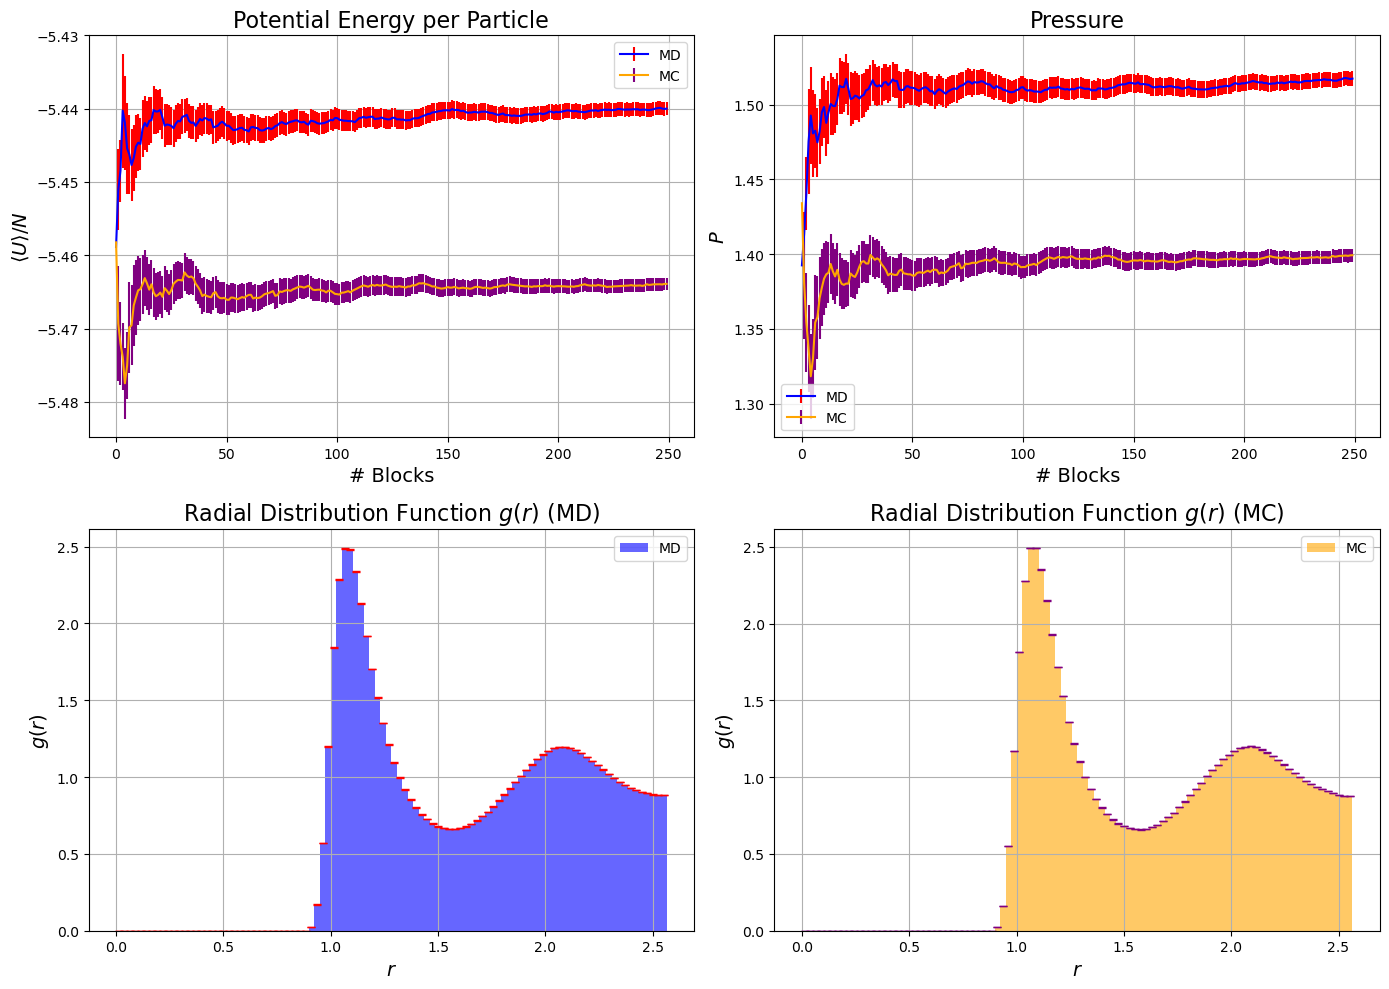

In [47]:
plot_results_3()

**Figure 4:** Comparison of Monte Carlo (MC) and Molecular Dynamics (MD) simulations for Argon at $\rho^\star = 0.8$ and $T^\star = 1.1$, with cutoff radius $r_c^\star = 2.5$. Top-left: average potential energy per particle $U/N$ as a function of the number of blocks. Top-right: average pressure $P$ as a function of the number of blocks. Bottom-left and bottom-right: radial distribution function $g(r)$ computed via histograms for MD and MC, respectively.



The results obtained with Molecular Dynamics (MD) and Monte Carlo (MC) simulations show a very good overall agreement.  
In MD, the system evolves deterministically in the **microcanonical ensemble (NVE)**, while in MC the configurations are generated stochastically through the Metropolis algorithm, which samples the **canonical ensemble (NVT)**.  

From a theoretical point of view, both ensembles are expected to yield the same equilibrium averages for macroscopic observables in the thermodynamic limit. Indeed, the computed potential energy per particle $U/N$, the pressure $P$, and the radial distribution function $g(r)$ obtained with the two methods are very close.  

